In [1]:
import numpy as np
import importlib
from datetime import datetime
import gc
import json
import os

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="1" # second gpu

In [3]:
from helpers import pre_processing_wlan_utils as preprocess_utils
from helpers import classifier_wlan_spectral_utils as classifier_utils
from helpers import tr_models as tr_models

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


# Keras API
from tensorflow.keras.callbacks import History, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, \
    Multiply, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, AveragePooling1D, AveragePooling2D, BatchNormalization, LSTM
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split

1 Physical GPUs, 1 Logical GPUs


In [5]:
importlib.reload(tr_models)
importlib.reload(classifier_utils)
importlib.reload(preprocess_utils)
gc.collect()

1 Physical GPUs, 1 Logical GPUs


125

In [6]:
num_iq_seq = 5000
input_shape = (2,num_iq_seq)

In [7]:
print('Getting data for model')
seed = 42
task = "app"
label = preprocess_utils.label_index[task]
num_classes = preprocess_utils.num_classes[task]
labels_string = preprocess_utils.labels_string[task]

#adapting for 7 labels
num_classes = num_classes-1
del labels_string[7]
print("Label id: ", label)
print("Num classes in that label: ", num_classes)
print("Labels: ", labels_string)

padding = 'post'
load_model=False
load_dir='../../models/'
load_file = '22042020175144_saved_wavenet_classifier'
dataset_folder = '../../dataset/waveforms/'
#dataset_filename='waveforms_SNR_v2_16042020_2G_n_mobile_7_classes_app_balanced.mat'
dataset_filename = 'waveforms_SNR_16042020_2G_n_mobile_app_new_app_balanced.mat'
Xraw, Yraw = classifier_utils.get_raw_xy_spectrum(dataset_folder,dataset_filename)

Getting data for model
Label id:  3
Num classes in that label:  7
Labels:  ['spotify', 'tunein', 'gpodcast', 'youtube', 'netflix', 'twitch', 'no-app']


100%|██████████| 71603/71603 [01:54<00:00, 627.22it/s]


In [8]:
X = classifier_utils.pad_or_trunc_x_and_scale(Xraw, num_iq_seq, padding, scale=False)

print("Oneshot labels")
Y = classifier_utils.get_one_hot_labels(Yraw, num_classes, label)
gc.collect()

100%|██████████| 71603/71603 [00:03<00:00, 19690.34it/s]


Oneshot labels
Labels created


22

In [9]:
print("Performing data splitting")
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

#x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size=0.2)
print(x_train.shape, x_test.shape)                     

print('Data Returned')
gc.collect()

Performing data splitting
(50122, 2, 5000) (21481, 2, 5000)
Data Returned


22

In [14]:
gc.collect()
X_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
X_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

dropout = 0.1
n_filters = 64
kernel_size = 9
pool = 4
batch_size = 48
epochs = 200

only_three = True

model = Sequential()
model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same', kernel_initializer="glorot_normal", input_shape=input_shape + (1,)))
model.add(MaxPooling2D(pool, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))
'''
model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_2, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_2, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_2, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Conv2D(n_filters, kernel_size, activation="relu", padding = 'same'))
model.add(MaxPooling2D(pool_2, padding='same'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))
'''
model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout))
model.add(BatchNormalization(axis=-1))

model.add(Dense(num_classes, activation='softmax'))


opt = "adam"

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 2, 5000, 64)       5248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1250, 64)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 1250, 64)       0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 1, 1250, 64)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1250, 64)       331840    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 313, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 313, 64)       

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')
callbacks = [early_stop]
result = model.fit(X_train_cnn, y_train, shuffle=True, validation_split=0.2, verbose = 1, 
                   batch_size=batch_size, epochs=epochs, callbacks=callbacks)

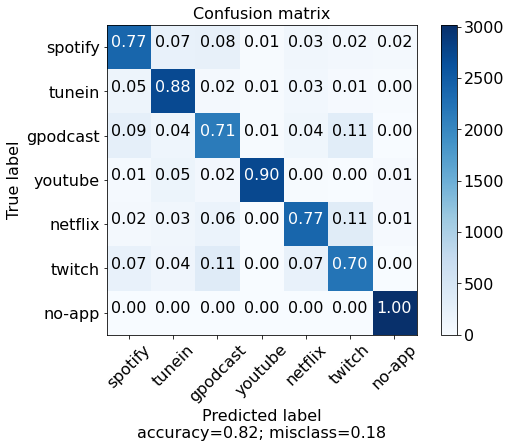

In [16]:
prefix = 'cnn_darpa_'+str(dropout)+'_'+str(n_filters)+'_'+str(kernel_size)+'_'+str(pool)+'_'+str(batch_size)+'_'+str(epochs)
classifier_utils.compute_and_save_conf_matrix(model, X_test_cnn, y_test, labels_string, filename_prefix = prefix, precision = "{:0.2f}")